In [2]:
pip install pandas_datareader

     |████████████████████████████████| 109 kB 5.6 MB/s            
You should consider upgrading via the '/opt/homebrew/Cellar/jupyterlab/3.3.2/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install yfinance

     |████████████████████████████████| 69 kB 4.3 MB/s            
     |████████████████████████████████| 2.9 MB 7.9 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 62 kB 10.6 MB/s             
     |████████████████████████████████| 502 kB 185.0 MB/s            
     |████████████████████████████████| 112 kB 175.0 MB/s            
     |████████████████████████████████| 142 kB 103.9 MB/s            
  Created wheel for peewee: filename=peewee-3.17.0-cp39-cp39-macosx_12_0_arm64.whl size=252855 sha256=fb7309a498a757f9b24982d06801a00fa9269bd04f8350390f53a325baf12f76
  Stored in directory: /Users/taegeon/Library/Caches/pip/wheels/77/6b/dc/722aee2a5d46a021ab67564c9d3d5536c3bd9577fcdc3a5aeb
Successfully built peewee
  Attempting uninstall: pytz
    Found existing installation: pytz 2022.1
    Uninstalling pytz-2022.1:
      Successfully uninstalled

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
import yfinance as yf

from pandas_datareader import data as pdr

In [11]:
yf.pdr_override()
df = pdr.get_data_yahoo("SPY", start="2017-01-01", end="2017-04-30")

[*********************100%%**********************]  1 of 1 completed


In [12]:
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005,200.629684,91366500
2017-01-04,225.619995,226.750000,225.610001,226.580002,201.823303,78744400
2017-01-05,226.270004,226.580002,225.479996,226.399994,201.662933,78379000
2017-01-06,226.529999,227.750000,225.899994,227.210007,202.384430,71559900
2017-01-09,226.910004,227.070007,226.419998,226.460007,201.716415,46939700


In [13]:
tmp_df = df[['Open','High','Low','Close']].copy()
tmp_df.head()

,Open,High,Low,Close
Date,,,,
2017-01-03,225.039993,225.830002,223.880005,225.240005
2017-01-04,225.619995,226.750000,225.610001,226.580002
2017-01-05,226.270004,226.580002,225.479996,226.399994
2017-01-06,226.529999,227.750000,225.899994,227.210007
2017-01-09,226.910004,227.070007,226.419998,226.460007


In [15]:
tmp_df['Open-Close'] = tmp_df['Open'] - tmp_df['Close']
tmp_df['High-Low'] = tmp_df['High'] - tmp_df['Low']
tmp_df = tmp_df.dropna()
X = tmp_df[['Open-Close','High-Low']]
Y = np.where(tmp_df['Close'].shift(-1) > tmp_df['Open'].shift(-1), 1, -1)
X.head()

,Open-Close,High-Low
Date,,
2017-01-03,-0.200012,1.949997
2017-01-04,-0.960007,1.139999
2017-01-05,-0.129990,1.100006
2017-01-06,-0.680008,1.850006
2017-01-09,0.449997,0.650009


In [16]:
x_min, x_max = X['Open-Close'].min() - .5, X['Open-Close'].max() + .5
y_min, y_max = X['High-Low'].min() - .5, X['High-Low'].max() + .5

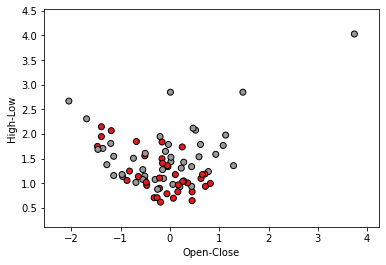

In [17]:
plt.scatter(X['Open-Close'], X['High-Low'], c=Y, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Open-Close')
plt.ylabel('High-Low')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [18]:
split_ratio = 0.7
split = int(split_ratio* len(tmp_df))
X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

In [19]:
train_acc = []
test_acc = []

for n in range(1,15):
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=n)
    clf.fit(X_train, Y_train)
    prediction = clf.predict(X_test)
    train_acc.append(clf.score(X_train, Y_train))
    test_acc.append((prediction==Y_test).mean())

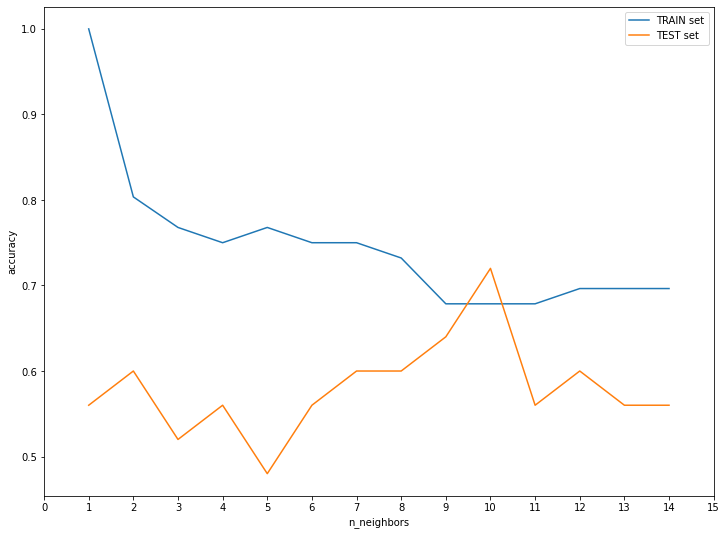

In [20]:
plt.figure(figsize=(12, 9))
plt.plot(range(1, 15), train_acc, label='TRAIN set')
plt.plot(range(1, 15), test_acc, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 16, step=1))
plt.legend()

In [21]:
knn = KNeighborsClassifier(n_neighbors = 10)

knn.fit(X_train,Y_train)

accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print('train accuracy : %.2f' % accuracy_train)
print('test accuracy : %.2f' % accuracy_test)

train accuracy : 0.68
test accuracy : 0.72


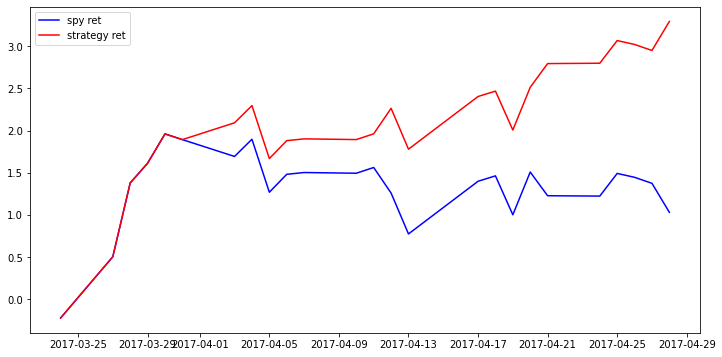

In [22]:
tmp_df['Predicted_Signal'] = knn.predict(X)

tmp_df['SPY_ret'] = np.log(tmp_df['Close'] / tmp_df['Open'])
cum_spy_ret = tmp_df[split:]['SPY_ret'].cumsum() * 100

tmp_df['strategy_ret'] = tmp_df['SPY_ret'] * tmp_df['Predicted_Signal'].shift(1)
cum_st_ret = tmp_df[split:]['strategy_ret'].cumsum() * 100

plt.figure(figsize=(12,6))
plt.plot(cum_spy_ret, color='b',label='spy ret')
plt.plot(cum_st_ret , color='r', label='strategy ret')
plt.legend()
plt.show()

In [23]:
print('TOTAL : ',tmp_df['Predicted_Signal'].count())
print('UP predict : ',tmp_df.loc[tmp_df['Predicted_Signal'] == 1,['Predicted_Signal']].count()[0])
print('DOWN predict : ',tmp_df.loc[tmp_df['Predicted_Signal'] == -1,['Predicted_Signal']].count()[0])

TOTAL :  81
UP predict :  58
DOWN predict :  23
